# Purpose: Finding the image registration points for the moving image (our images)

*Step 1: Importing necessary packages*

In [1]:
# operating system dependent functionality
import os
#allows for all the pathnames of a specified pattern to be located
from glob import glob

#Package imports
import numpy as np
from PIL import Image
import nibabel as nib
import nrrd
import pandas as pd
import cv2


import matplotlib.pyplot as plt

%matplotlib inline

#Skimage Filters specfically for image preprocessing
from skimage import io
from skimage import filters
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import  closing, square, remove_small_objects
from skimage.color import label2rgb
from skimage.transform import rescale, resize

*Step 2: Importing the images*

In [2]:
#Plug in the hard drive ("Hawley")

In [3]:
im3 = io.imread('/Volumes/imagereg/6-26-19-tiffexport/test3.tif')

In [4]:
im3.shape

(7, 5390, 3609, 3)

*Step 3: Checking shapes*

In [5]:
print(im3.shape, im3.dtype, type(im3)) 

(7, 5390, 3609, 3) uint16 <class 'numpy.ndarray'>


*Step 4: Split the r,g,b channels*

In [6]:
red3 = im3[:, :, :, 0]
green3 = im3[:, :, :, 1]
blue3 = im3[:, :, :, 2]

*Step 5: Compressing the z-stack*

In [7]:
im_max_3= np.max(blue3, axis=0)

*Step 6: Viewing the images*

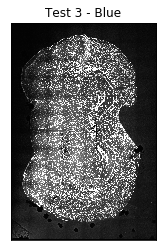

In [8]:
plt.imshow(im_max_3, cmap = 'gray')
plt.title('Test 3 - Blue')
plt.xticks([])
plt.yticks([])

plt.show()

*Step 7: Trying to the edge detector on this image*

*Step 7a: Gaussian blur*

In [9]:
gauss = filters.gaussian(im_max_3, sigma=11, output=None, mode='nearest', cval=0, multichannel=None, preserve_range=False, truncate=4.0)

*Step 7b: Sobel Edge Detector*

In [10]:
edge_sobel = filters.sobel(gauss)

*Step 7c: Threshold Applied*

In [11]:
threshold = filters.threshold_otsu(edge_sobel)
binary = edge_sobel > threshold

*Step 7d: Removing small objects*

In [12]:
binary2 = remove_small_objects(binary, min_size=3000, connectivity=1, in_place=True)

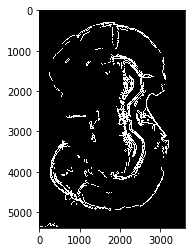

In [13]:
plt.imshow(binary2, cmap='gray')

*Step 7e: Clean the Corners*

In [14]:
imagex, imagey = binary2.shape

In [15]:
xrange = int(imagex/10)
yrange = int(imagey/10)

xfull = imagex
yfull= imagey

binary2[(xfull-xrange):xfull , 0:1000] = False


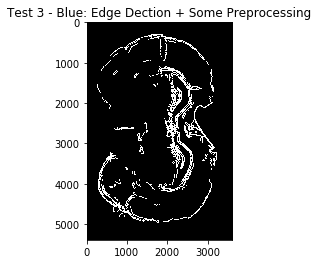

In [16]:
plt.imshow(binary2, cmap = 'gray')
plt.title('Test 3 - Blue: Edge Dection + Some Preprocessing')

plt.show()

*Step 8: Find local minimum and Maximum points*

In [17]:
def x_value(binary_image):
    #Trying to find the relative maximum at the top of the slice in a new way
    for x in range(binary_image.shape[0]):
        unique_array = np.unique(binary_image[x], axis=0)
        if unique_array.shape[0] == 2:
            break
    return x

In [18]:
def y_values(binary_image):
    x = x_value(binary_image)
    y_list = []
    for y in range(binary_image[x].size):
        image = binary_image[x]
        value = image[y]
        if value == True:
            y_list.append (y)
        else:
            pass
    y_list = np.array(y_list)
    return y_list

In [19]:
def point_middle(binary_image):
    x = x_value(binary_image)
    y = y_values(binary_image)
    middle = np.median(y)
    midpoint = int(middle)
    return midpoint

In [20]:
def local_max(binary_image):
    x = x_value(binary_image)
    y = point_middle(binary_image)
    return x, y

In [21]:
def minx_value(binary_image):
    #Trying to find the relative maximum at the top of the slice in a new way
    xlist = reversed(range(binary_image.shape[0]))
    for x in xlist:
        unique_array = np.unique(binary_image[x], axis=0)
        if unique_array.shape[0] == 2:
            break
    return x

In [22]:
def miny_values(binary_image):
    x = minx_value(binary_image)
    y_list = []
    for y in range(binary_image[x].size):
        image = binary_image[x]
        value = image[y]
        if value == True:
            y_list.append (y)
        else:
            pass
    y_list = np.array(y_list)
    return y_list

In [23]:
def min_middle(binary_image):
    x = minx_value(binary_image)
    y = miny_values(binary_image)
    middle = np.median(y)
    midpoint = int(middle)
    return midpoint

In [24]:
def local_min(binary_image):
    x = minx_value(binary_image)
    y = min_middle(binary_image)
    return x, y

Splitting the binary 2 image in half

In [25]:
binary_half = np.split(binary2,2)

In [26]:
left1 = binary_half[0]

In [27]:
left1 = np.rot90(left1, k=1)

In [28]:
left2 = binary_half[1]

In [29]:
left2 = np.rot90(left2, k=1)

*Finding the point coordinates*

In [30]:
x1, y1 = local_max(binary2)
x4, y4 = local_min(binary2)
sy2, x2 = local_max(left1)
sy6, x6 = local_min(left1)
y3, sx3 = local_max(left2)
sy5, sx5 = local_min(left2)

In [31]:
#Function for making the red dot to check the registration points

In [32]:
def red_points(checkx, checky):
    checkpoints [checkx, checky] = 255
    kernel = list(range(1,50))
    xvalues = list(range(checkx - 50, checkx+50))
    for x in xvalues: 
        for distances in kernel:
            checkpoints[x, (checky - distances):(checky+distances), 0:1] = 255
    return

In [33]:
binaryx, binaryy = binary.shape
lx, ly = left1.shape

In [34]:
checkpoints = np.zeros([binaryx, binaryy, 3], dtype=np.uint8)

x2 = x2
y2 = binaryy - sy2
x3 = sx3 + ly 
y3 = (binaryy - y3)
x5 = sx5 + ly
y5 = (binaryy - sy5)
y6 = (binaryy - sy6)


red_points(x1,y1)
red_points(x2,y2)
red_points(x3,y3)
red_points(x4,y4)
red_points(x5,y5)
red_points(x6,y6)

*Showing the registration points on the image as a checkpoint*

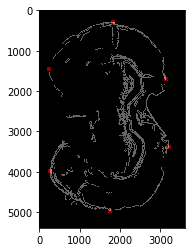

In [35]:
plt.imshow(binary2, cmap='gray')
plt.imshow(checkpoints, alpha=0.6);

*Creating a pandas dataframe of the values to be used for registration*

In [36]:
coor = {'M_x': [x1, x2, x3, x4, x5, x6], 'M_y': [y1, y2, y3, y4, y5, y6]}

In [37]:
df = pd. DataFrame(coor, columns = ['M_x', 'M_y'])
df

,M_x,M_y
0,287,1822
1,1695,3141
2,3383,3225
3,4968,1756
4,3985,264
5,1464,239


In [38]:
export_csv = df.to_csv('/Volumes/imagereg/6-26-19-tiffexport/M_regPoints_csv', index = None)